In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_style('whitegrid')

In [3]:
#prices

fuels = pd.read_csv('fuels.csv')
cap = pd.read_csv('cap.csv')

In [4]:
dam = pd.read_csv('dam.csv')

dam['Date'] = pd.to_datetime(dam['Date'])

dam = (dam
       .set_index(dam['Date']) # pd.to_datetime(dam['Date'])
       .drop('Date', axis = 1)
       )

dam = dam.reset_index().rename(columns = {'Date': 'date_old'})
dam['date_new'] = dam['date_old'] - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

dam = dam.drop('date_old', axis = 1).rename(columns = {'date_new': 'Date'}).set_index('Date')

dam.columns = ['nyca_dam', 'nyc_dam', 'li_dam', 'gj_dam']

In [5]:
fuels = (fuels
         .set_index(pd.to_datetime(fuels['Date']))
         .drop('Date', axis = 1)
        )

In [6]:
cap = (cap
       .set_index(pd.to_datetime(cap['Date'], format = '%b-%y'))
       .drop('Date', axis = 1)
       )
cap.columns = ['nyca_icap', 'gj_icap', 'nyc_icap', 'li_icap']

In [7]:
locs = ['GJ', 'LI', 'NYC']

gen = {}

for loc in locs:
    gen[loc] = pd.read_csv(f'../data\Generating_Capacity_{loc}_11-23.csv')
    gen[loc] = (gen[loc]
                .set_index(pd.to_datetime(gen[loc]['Date']))
                .drop('Date', axis = 1))

gen['NYCA'] = pd.read_csv('../data\Generating_Capacity_NYCA_04-23.csv')
gen['NYCA'] = (gen['NYCA']
               .set_index(pd.to_datetime(gen['NYCA']['Date']))
               .drop('Date', axis = 1))

In [8]:
ucap = pd.read_csv("../data/Monthly_UCAP_Requirements.csv")
ucap = (ucap
        .set_index(pd.to_datetime(ucap['Date']))
        .drop('Date', axis = 1)
        )

In [9]:
above = pd.read_csv('../data/Monthly_Percent_Cleared_Above.csv')
above = (above
        .set_index(pd.to_datetime(above['Date']))
        .drop('Date', axis = 1)
        )

In [10]:
# shift generating capacity by two years (approximate construction time of a power plant)
locs = ['GJ', 'LI', 'NYC', 'NYCA']
gen_shifted = {}
for loc in locs:
    gen_shifted[loc] = gen[loc].shift(periods=3, freq="y").shift(periods=1, freq="d")

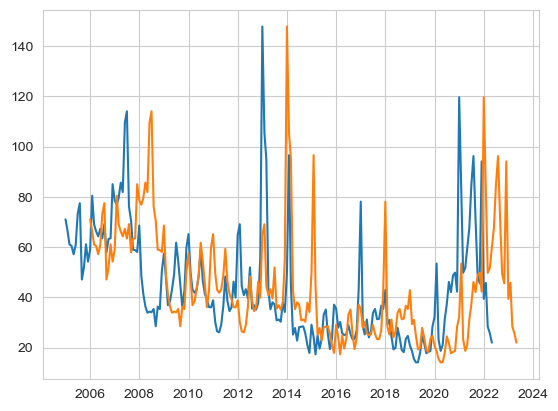

In [77]:
icap_4 = pd.DataFrame()
icap_4['ICAP-4'] = cap['nyca_icap'].shift(periods=-37, freq="m").shift(periods=1, freq="d")

icap_3 = pd.DataFrame()
icap_3['ICAP-3'] = cap['nyca_icap'].shift(periods=-25, freq="m").shift(periods=1, freq="d")

icap_2 = pd.DataFrame()
icap_2['ICAP-2'] = cap['nyca_icap'].shift(periods=-13, freq="m").shift(periods=1, freq="d")


dam_2 = pd.DataFrame()
dam_2['DAM-2'] = dam['nyca_dam'].shift(periods=-13, freq="m").shift(periods=1, freq="d")

plt.plot(dam_2['DAM-2'])
plt.plot(dam['nyca_dam'])

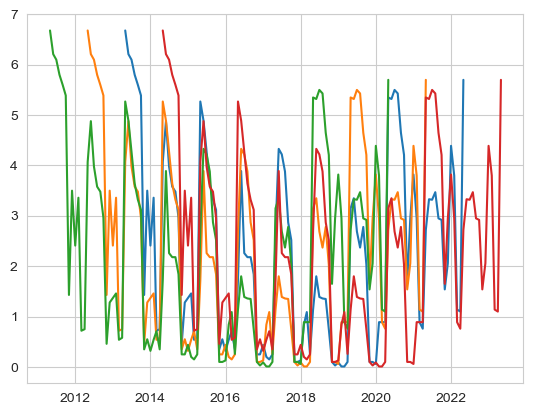

In [78]:
plt.plot(icap_2['ICAP-2'])
plt.plot(icap_3['ICAP-3'])
plt.plot(icap_4['ICAP-4'])
plt.plot(cap['nyca_icap'])

In [79]:
reg = (gen['NYCA']
       .join(cap)
       .join(fuels)
       .join(dam)
       .join(above)
       .join(ucap)
       #.join(icap_1)
       .join(icap_2)
       .join(icap_3)
       .join(icap_4)
       #.join(dam_1)
       .join(dam_2)
       .dropna(axis = 0)
       )

In [80]:
reg.columns

Index(['Gas (NYCA)', 'Coal (NYCA)', 'Oil (NYCA)', 'Renewables (NYCA)',
       'Others (NYCA)', 'Sum (NYCA)', 'nyca_icap', 'gj_icap', 'nyc_icap',
       'li_icap', 'coal', 'petroleum', 'natural gas', 'nyca_dam', 'nyc_dam',
       'li_dam', 'gj_dam', 'Cleared Above NYCA (%)', 'Cleared Above GJ (%)',
       'Cleared Above NYC (%)', 'Cleared Above LI (%)', 'UCAP NYCA (MW)',
       'UCAP GJ (MW)', 'UCAP NYC (MW)', 'UCAP LI (MW)', 'ICAP-2', 'ICAP-3',
       'ICAP-4', 'DAM-2'],
      dtype='object')

In [94]:
df = reg[['Gas (NYCA)', 
          #'Coal (NYCA)',
          #'Oil (NYCA)', 
          #'Renewables (NYCA)', 
          #'Others (NYCA)',
          #'Sum (NYCA)',
          'nyca_icap',
          #'natural gas', 
          'nyca_dam', 
          #'Cleared Above NYCA (%)', 
          #'UCAP NYCA (MW)',
          'ICAP-2',
          #'ICAP-3',
          #'ICAP-4', 
          'DAM-2'
          ]]

<Axes: >

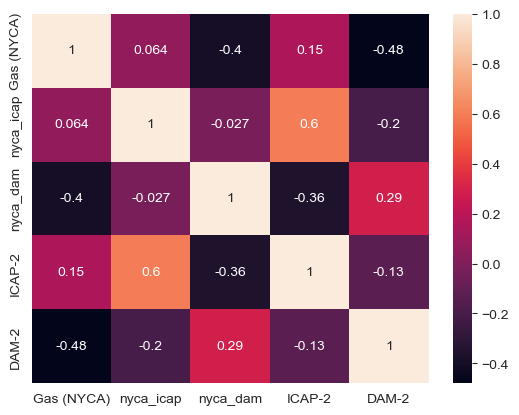

In [95]:
sns.heatmap(df.corr(), annot = True)

In [96]:
X, y = df.loc[:, df.columns != 'Gas (NYCA)'], df['Gas (NYCA)']
X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             Gas (NYCA)   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     4.165
Date:                Fri, 09 Jun 2023   Prob (F-statistic):            0.00680
Time:                        17:44:39   Log-Likelihood:                -315.99
No. Observations:                  43   AIC:                             642.0
Df Residuals:                      38   BIC:                             650.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.408e+04    241.416     99.747      0.0

In [97]:
sm.stats.linear_rainbow(result)

(11.35684016026902, 4.354481863467282e-06)